# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

#### Write your answer here and turn the cell type into markdown

**Business Goal and Metric**
The business goal is to create a feature within the booking platform that flags potential weather-related delays. This will help improve customer satisfaction by providing timely information about potential disruptions, which can also improve retention and encourage future bookings.

A key business metric for success is the prediction accuracy of the delay model. We can aim for a target accuracy or F1 score above a certain threshold (e.g., 85%) to ensure reliable information is communicated to customers. A secondary metric could be the reduction in customer complaints or increase in booking satisfaction scores after implementing this feature.

**Machine Learning Problem Statement**
The goal is to predict whether a given flight will be delayed due to weather based on historical data, which includes features such as date, time, origin, destination, airline, and distance. This is a classification problem where the model will output a binary prediction of "delayed" or "on-time" due to weather.

**Why ML is an Appropriate Solution**
Given the number of factors contributing to flight delays and the historical data available, machine learning is suitable because:

**Complex Patterns**: Weather-related delays may have complex patterns that traditional rules-based systems would struggle to capture.
**Historical Data**: There is ample historical data that can be used to identify trends and patterns in delay occurrences.
**Prediction Capability**: Machine learning models can provide timely predictions and probabilistic outcomes, which are valuable in risk-based decision-making scenarios like travel delays.
Type of Machine Learning

This represents a supervised learning problem, specifically a classification task, as we are training a model to categorize each flight as "delayed" or "not delayed" based on historical features.

### 2. Formulate the business problem, success metrics, and desired ML output.

The travel booking website aims to proactively inform customers if their flights are likely to be delayed due to weather conditions. By identifying these delays at the time of booking, the company hopes to enhance customer satisfaction and reduce potential disruptions for travelers. Given the vast number of daily flights and the complexity of weather impacts on flight schedules, this solution will focus on flights from the busiest domestic airports in the U.S., where delays are most impactful on travelers.

**Success Metrics**
1. Prediction Accuracy Score: The primary success metric is the accuracy score of the model in correctly predicting weather-related delays. High accuracy or F1 score ensures that predictions are reliable, which is essential for user trust.
2. Reduction in Customer Complaints: A secondary metric is a measurable decrease in complaints related to unexpected delays after the feature is implemented.
Customer Satisfaction Score Improvement: Customer satisfaction surveys can be used to gauge how well the new feature meets user expectations, providing qualitative feedback on the added value of predictive delay notifications.

**Desired ML Output**
The machine learning model should output a binary classification for each flight:

1: Delayed due to weather
0: Not delayed due to weather
The model should also output the probability of delay, which can allow for threshold-based decision-making, such as only notifying users if the delay probability exceeds a certain level (e.g., 70%). This probabilistic output will enable more flexible customer interactions and allow for updates or additional guidance based on delay likelihood.

#### Write your answer here and turn the cell type into markdown

Given data on flight schedules, actual departure and arrival times, weather conditions, and historical delay information, we aim to build a machine learning model that predicts if a flight will be delayed due to weather conditions. The model should accurately classify flights as either "on-time" or "delayed" based on input features available at the time of booking.


### 3. Identify the type of ML problem you’re dealing with.

#### Write your answer here and turn the cell type into markdown

This is a supervised learning problem, specifically a binary classification problem.

In this case, I am trying to classify each flight as either "delayed due to weather" or "not delayed due to weather" based on historical data, which includes features like date, time, origin, destination, airline, and distance. Since I have labeled data where each record has a known outcome (whether it was delayed due to weather), a supervised classification model is ideal for this task.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [3]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [4]:
# download the files

# <note: make them all relative, absolute path is not accepted>
zip_path = 'data/zip_files' #path to the zip files
base_path = 'data/combined_data'  #the folder that contains the whole project (data and code)
csv_base_path = 'data/extracted_files' #path to where you want the zip files extracted

# !mkdir -p {csv_base_path}
# Ensure extraction directory exists
os.makedirs(csv_base_path, exist_ok=True)

In [5]:
# How many zip files do we have? write a code to answer it.

# List all files in the directory and count those ending with .zip
zip_files = [file for file in os.listdir(zip_path) if file.endswith('.zip')]
num_zip_files = len(zip_files)

print(f"Number of zip files: {num_zip_files}")

Number of zip files: 60


#### Extract CSV files from ZIP files

In [6]:
# Function to extract all files in a zip archive to a specified directory
def zip2csv(zipFile_name, file_path):
    """
    Extract csv from zip files.
    zipFile_name: name of the zip file.
    file_path: path to the folder where CSVs will be stored.
    """
    try:
        with ZipFile(zipFile_name, 'r') as z:
            print(f'Extracting {zipFile_name} to {file_path}')
            z.extractall(path=file_path)
    except Exception as e:
        print(f'zip2csv failed for {zipFile_name}: {e}')

# List all ZIP files in the zip_path directory
zip_files = [os.path.join(zip_path, file) for file in os.listdir(zip_path) if file.endswith('.zip')]

# Extract each ZIP file in zip_files to the csv_base_path
for file in zip_files:
    zip2csv(file, csv_base_path)

print("All files extracted to", csv_base_path)


Extracting data/zip_files\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip to data/extracted_files
Extracting data/zip_files\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip to data/extracted_files
Extracting data/zip_files\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip to data/extracted_files
Extracting data/zip_files\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip to data/extracted_files
Extracting data/zip_files\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip to data/extracted_files
Extracting data/zip_files\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip to data/extracted_files
Extracting data/zip_files\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip to data/extracted_files
Extracting data/zip_files\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_5.zip to data/extracted_files
Extracting data/zip_files\On_Time_Rep

In [7]:
# How many csv files have we extracted? write a code to answer it.
# List all files in the directory and count those ending with .csv
csv_files = [file for file in os.listdir(csv_base_path) if file.endswith('.csv')]
num_csv_files = len(csv_files)

print(f"Number of CSV files extracted: {num_csv_files}")

Number of CSV files extracted: 60


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [8]:
html_file_path = Path(csv_base_path) / 'readme.html'

# Check if the HTML file exists and read its content
if html_file_path.exists():
    with open(html_file_path, 'r') as file:
        html_content = file.read()
    print("HTML file content loaded successfully.")
else:
    print("readme.html not found in the extracted files directory.")

HTML file content loaded successfully.


In [9]:
from IPython.display import IFrame
html_file_path = os.path.join(csv_base_path, 'readme.html')

# Display the HTML file using IFrame
IFrame(src=os.path.relpath(html_file_path), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [10]:
df_temp = pd.read_csv("data/extracted_files/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv") # **ENTER YOUR CODE HERE**

**Question**: Print the row and column length in the dataset, and print the column names.

In [11]:
df_shape = df_temp.shape # **ENTER YOUR CODE HERE**
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [12]:
# Enter your code here

df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [13]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:# **ENTER YOUR CODE HERE**
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [14]:
# Enter your code here

# [x for x in df_temp_cols if x == 'Del']
for x in df_temp.columns:
    if 'Del' in x:
        print(x)

DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
DivArrDelay


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [15]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", df_temp.shape[0]  , " and ", df_temp.shape[1] )
print("The years in this dataset are: ", df_temp['Year'].unique())
print("The months covered in this dataset are: ", df_temp['Month'].unique())
print("The date range for data is :" , min(df_temp['FlightDate']), " to ", max(df_temp['FlightDate']))
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))


The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [16]:
counts = pd.DataFrame({'Origin':df_temp['Origin'].value_counts(), 'Destination':df_temp['Dest'].value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [17]:
counts.sort_values(by=['Origin', 'Destination'],ascending=False).head(15 )# Enter your code here

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

#### Enter your answer here

Yes, 
I can predict if a flight would be delayed by building a machine learning model using flight data. <br>
Here’s the approach: <br>

**1. Data Preprocessing**: Clean the data and encode categorical variables (e.g., airline, origin). <br>
**2. Feature Engineering**: Create new features like time of day, season, and historical weather. <br>
**3. Model Training**: Use a binary classifier (e.g., Random Forest) to distinguish between delayed and on-time flights. <br>
**4. Evaluation**: Test and validate the model to ensure accurate predictions.  <br>
Incorporating features like weather, airline-specific patterns, and peak times will improve prediction accuracy, helping to notify customers of potential delays.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [18]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    file_name: name of file to save combined dataset
    """
    # Create an empty dataframe
    df = pd.DataFrame()
    
    
    # Loop through each CSV file
    for file in csv_files:
        # Read the current CSV file
        temp_df = pd.read_csv(file)
        
        # Filter the columns based on filter_cols
        temp_df = temp_df[filter_cols]
        
        # Apply subsetting for each column in subset_cols with corresponding values in subset_vals
        for col, vals in zip(subset_cols, subset_vals):
            temp_df = temp_df[temp_df[col].isin(vals)]
        
        # Append the filtered and subsetted data to the main DataFrame
        df = pd.concat([df, temp_df], ignore_index=True)
    
    # Save the combined DataFrame to a CSV file
    df.to_csv(file_name, index=False)
    print(f"Combined CSV saved to {file_name}")
    # #<complete the code of this function>
    # for csv_file in csv_files:
    #     print(f'Reading {csv_file}')
    #     # Read csv file
    #     temp_df = pd.read_csv(f"data/extracted_files/{csv_file}")
        
    #     # Filter columns
    #     temp_df = temp_df[filter_cols]
        
    #     # Subset values
    #     for i in range(len(subset_cols)):
    #         temp_df = temp_df[temp_df[subset_cols[i]].isin(subset_vals[i])]
        
    #     # Concatenate dataframes
    #     df = pd.concat([df, temp_df])
        
    # return df

In [19]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [20]:
start = time.time()

combined_csv_filename = f"{base_path}combined_files.csv"

csv_files = [os.path.join(csv_base_path, file) for file in os.listdir(csv_base_path) if file.endswith('.csv')]

# < write code to call the combined_csv function>
combined_df = combine_csv(csv_files, cols, subset_cols, subset_vals,  combined_csv_filename)



print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

Combined CSV saved to data/combined_datacombined_files.csv
csv's merged in 3.14 minutes


#### Load dataset

Load the combined dataset.

In [59]:
data = pd.read_csv(combined_csv_filename)# Enter your code here to read the combined csv file.


Print the first 5 records.

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [60]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", list(data['Year'].unique()))
print("The months covered in this dataset are: ", sorted(list(data['Month'].unique())))
print("The date range for data is :" , min(data['FlightDate']), " to ", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))


The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [61]:
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True) # Enter your code here

# Update 'is_delay' column to 1 if arrival delay is more than 15 minutes, otherwise 0
data['is_delay'] = data['ArrDelayMinutes'].apply(lambda x: 1 if x > 15 else 0)

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [62]:
# Enter your code here

data.isnull().sum(axis=0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay                 0
AirTime              22540
dtype: int64

The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [63]:
### Remove null columns
data = data[~data['ArrDelay'].isnull()]
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,is_delay,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,0.0,689.0,3,-20.0,0.0,0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,0.0,731.0,3,-3.0,0.0,0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,0.0,1199.0,5,-7.0,0.0,0,174.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,0.0,0.0,1587.0,7,-4.0,0.0,0,233.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,0.0,0.0,1587.0,7,-13.0,0.0,0,179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658125,2018,3,9,11,2,2018-09-11,WN,DEN,CO,PHX,AZ,1105,0.0,0.0,602.0,3,-18.0,0.0,0,87.0
1658126,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,CA,825,0.0,0.0,967.0,4,-8.0,0.0,0,133.0
1658127,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,CA,1240,0.0,0.0,967.0,4,17.0,17.0,1,141.0
1658128,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,CA,2210,0.0,0.0,967.0,4,2.0,2.0,0,138.0


# You Reached Here

Get the hour of the day in 24-hour time format from CRSDepTime.

In [64]:

# Extracting the hour of the day in 24-hour format from the 'CRSDepTime' column
# As 'CRSDepTime' is in HHMM format (e.g., 2145 means 21:45)

# Converting 'CRSDepTime' to the hour by dividing by 100 and taking the integer part
data['DepHourofDay'] = data['CRSDepTime'] // 100


In [65]:
print(data.head())

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest  ... CRSDepTime  Cancelled  Diverted  Distance  \
0    ATL          GA  IAH  ...       2145        0.0       0.0     689.0   
1    DFW          TX  ATL  ...        945        0.0       0.0     731.0   
2    ATL          GA  DEN  ...       1855        0.0       0.0    1199.0   
3    ATL          GA  PHX  ...       1634        0.0       0.0    1587.0   
4    PHX          AZ  ATL  ...        700        0.0       0.0    1587.0   

   DistanceGroup  ArrDelay  ArrDelayMinutes  is_delay  AirTime

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

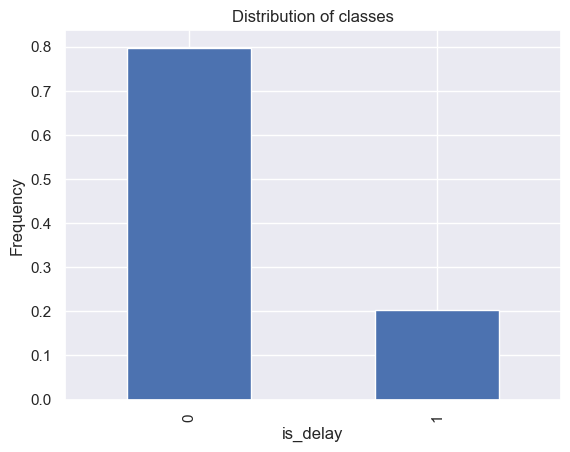

In [66]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

#### Enter your answer here and turn the cell type to markdown

The bar plot indicates a significant imbalance between flights that arrived on time (0) and those delayed by more than 15 minutes (1). The majority of flights were on time almost 80%, with a much higher frequency in the "no delay" category, resulting in a skewed distribution towards on-time arrivals. This imbalance suggests that adjustments are needed to balance both outcomes for effective machine learning modeling.

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?


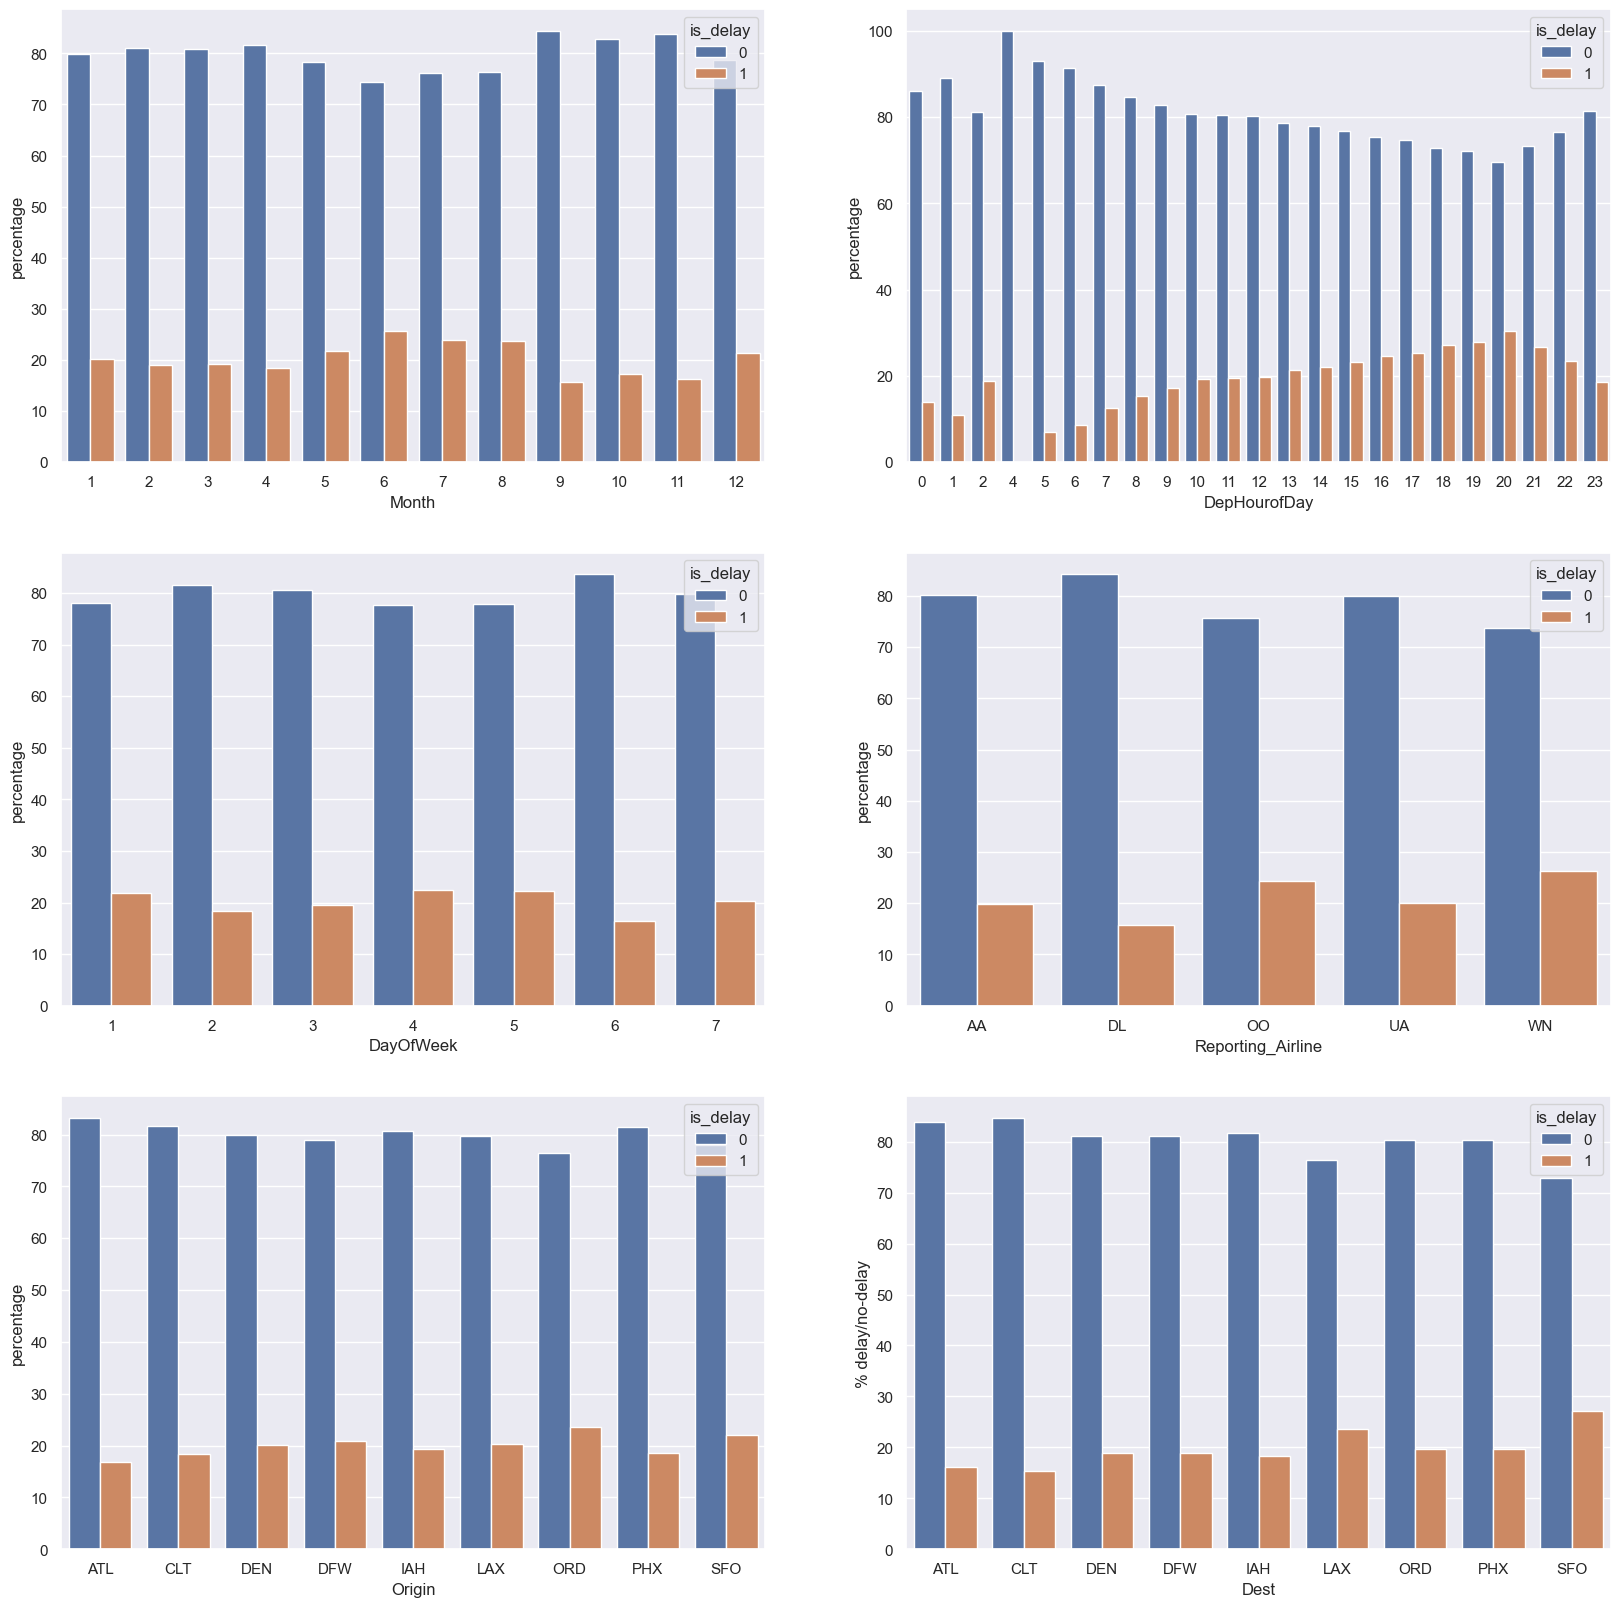

In [67]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

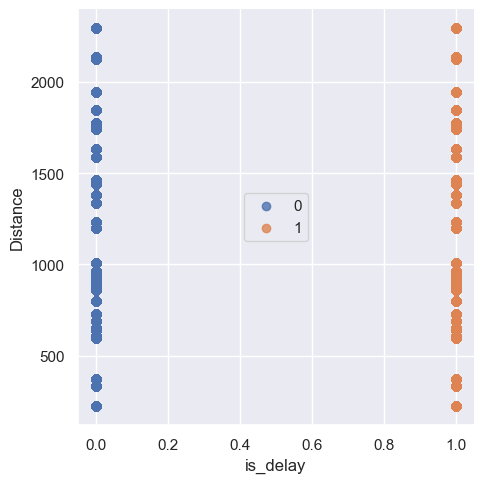

In [68]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

#### Based on the above figures, enter your answers to the above questions here and turn the cell type to markdown

**Answers**
- ***Months with Most Delays:*** The delay percentages across months are relatively consistent, with no particular month showing a significantly higher rate of delays. However, June, July and August show a slightly higher delay rate compared to the other months.
- ***Time of Day with Most Delays:*** Delays are more frequent during the late afternoon and early evening hours, particularly from around 15:00 to 20:00. Earlier in the day, delays are less common, with the early morning hours showing the lowest delay percentages.
- ***Day of the Week with Most Delays:*** The distribution of delays is fairly even across the days of the week, with no specific day showing a significantly higher delay rate. Nevertheless, Monday, Thursday, and Friday have marginally higher delay.
- ***Airline with Most Delays:*** All airlines exhibit similar delay percentages, with none showing a substantially higher rate of delays (over 15 minutes) compared to the others. However OO and WN airlines have slight higher delay.
- ***Origin and Destination Airports with Most Delays:*** The delay rates across various origin and destination airports are quite similar, showing only minor variations, indicating that no specific airport experiences notably more delays than others. Even so, ORD shows a slightly higher delay rate as an origin, while LAX shows a higher delay rate as a destination, and SFO has a slightly elevated delay rate in both origin and destination categories.
- ***Flight Distance as a Factor in Delays:*** Based on the scatter plot, flight distance does not appear to be a strong factor in determining delays. Both on-time flights (0) and delayed flights (1) are spread across a wide range of distances, with no clear pattern indicating that longer or shorter flights are more prone to delays. Delays are observed across various distances, suggesting that factors other than distance likely play a more significant role in affecting delay rates.


### Features

Look at all the columns and what their specific types are.

In [69]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [70]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay               int64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

**Bucketizing the DepHourofDay** <br>

The **DepHourofDay** variable was bucketed into four categories—Early Morning, Morning, Afternoon, and Evening—based on typical airline delay patterns observed in the previous bar graph:

***Early Morning (1-6):*** These hours tend to have lower delay rates, likely due to lower traffic and fewer flights, meaning fewer cascading delays from earlier flights.

***Morning (7-12):*** The delay rate starts to increase as traffic builds up with more flights, but it remains moderate. Morning flights generally experience fewer delays as operations are just starting and less backlog has accumulated.

***Afternoon (13-18):*** This period shows a noticeable increase in delay rates, often due to peak traffic levels and accumulated delays from earlier flights. Afternoon flights are more prone to delays as airports reach peak operation.

***Evening (19-23):*** Delays tend to rise further, possibly due to cumulative delays throughout the day and operational constraints, such as reduced staffing in some airports at night.

This bucketing helps capture daily delay trends while simplifying the dataset by reducing 24 unique hours into meaningful categories related to the likelihood of delays.

In [71]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')# Enter your code here


def bucket_dep_hour(hour):
    if 1 <= hour <= 6:
        return 'Early Morning'
    elif 7 <= hour <= 12:
        return 'Morning'
    elif 13 <= hour <= 18:
        return 'Afternoon'
    else:
        return 'Evening'

data['DepHourofDay'] = data['DepHourofDay'].apply(bucket_dep_hour).astype('category')



data.head()

,is_delay,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,Distance,DepHourofDay
0,0,1,1,26,7,DL,ATL,IAH,689.0,Evening
1,0,1,1,26,7,DL,DFW,ATL,731.0,Morning
2,0,1,1,26,7,DL,ATL,DEN,1199.0,Afternoon
3,0,1,1,26,7,DL,ATL,PHX,1587.0,Afternoon
4,0,1,1,26,7,DL,PHX,ATL,1587.0,Morning


To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [72]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

Check the length of the dataset and the new columnms.

In [73]:
# Enter your code here
# length of the dataset
data.shape

(1635590, 75)

In [74]:
# Enter your code here
# new columnms
data.columns

Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [75]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

In [76]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B

data.to_csv('data/combined_csv_v1.csv', index=False)

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [77]:
# write Code here to split data into train, validate and test

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)

### Baseline classification model

In [78]:
# <write code here>

from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(train_data.drop('target', axis=1), train_data['target'])

predictions = logisticRegr.predict(test_data.drop('target', axis=1))

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [79]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    # complete the code here
    cm = confusion_matrix(test_labels, target_predicted)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(logisticRegr.score(test_data.drop('target', axis=1), test_data['target']))
    plt.title(all_sample_title, size = 15)

In [80]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
def plot_roc(test_labels, target_predicted):
    # complete the code here
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

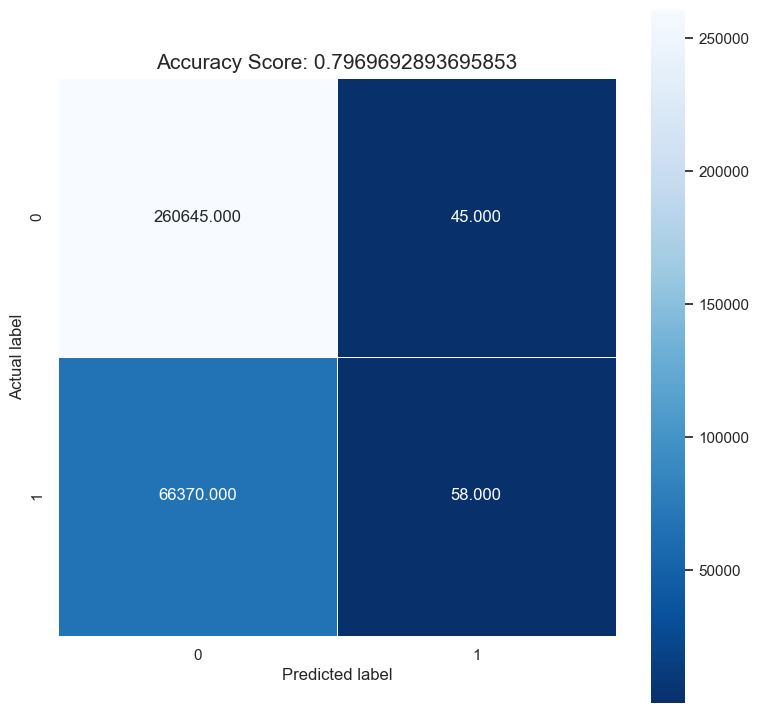

In [81]:
# Enter you code here
plot_confusion_matrix(test_data['target'], predictions)

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

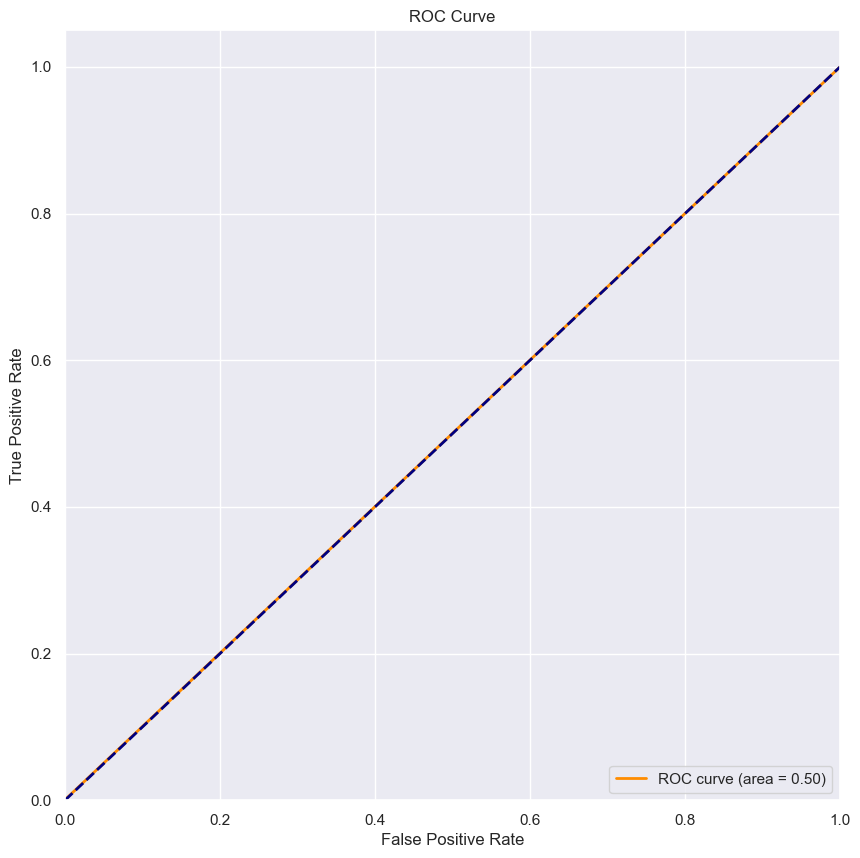

In [82]:
# Enter you code here
plot_roc(test_data['target'], predictions)

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

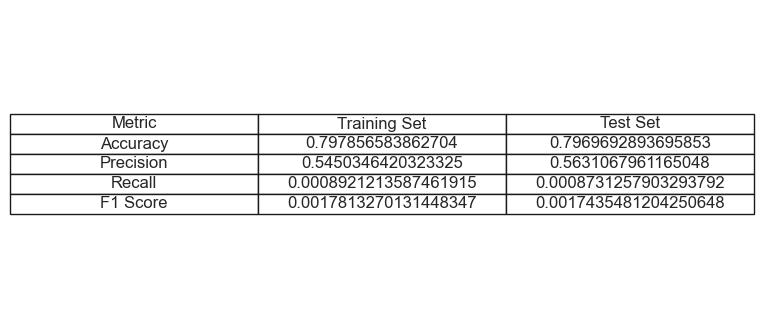

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions on the training set
train_predictions = logisticRegr.predict(train_data.drop('target', axis=1))

# Calculate metrics for the training set
train_accuracy = accuracy_score(train_data['target'], train_predictions)
train_precision = precision_score(train_data['target'], train_predictions, pos_label=1)
train_recall = recall_score(train_data['target'], train_predictions, pos_label=1)
train_f1 = f1_score(train_data['target'], train_predictions, pos_label=1)

# Calculate metrics for the test set
test_accuracy = accuracy_score(test_data['target'], predictions)
test_precision = precision_score(test_data['target'], predictions, pos_label=1)
test_recall = recall_score(test_data['target'], predictions, pos_label=1)
test_f1 = f1_score(test_data['target'], predictions, pos_label=1)

# Create a DataFrame to store the metrics
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Training Set": [train_accuracy, train_precision, train_recall, train_f1],
    "Test Set": [test_accuracy, test_precision, test_recall, test_f1]
}
metrics_df = pd.DataFrame(metrics_data)

# Plot the table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust figure size as needed
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Adjust table size as needed

plt.show()


#### Answers 

1. The model's performance on the test set is very similar to that on the training set, with nearly identical values for accuracy, precision, recall, and F1-score. This suggests that the model has generalized well and is not overfitting. However, both training and test recall values are extremely low, indicating that the model struggles to identify the positive class (delayed arrivals). This is due to class imbalance as shown in pervious graph, where the model learns to prioritize predicting the majority class.

2. Yes, there are significant differences between accuracy, precision, and recall. While the accuracy is relatively high at around 79.7%, recall is extremely low (approximately 0.08% on both training and test sets). This discrepancy is likely due to the class imbalance, where most flights are predicted as on time, leading to a high number of false negatives (missed delays). The high accuracy reflects correct predictions for the majority class, while the low recall shows poor performance in identifying delayed flights, resulting in a low F1-score.

3. From a business perspective, the current recall and F1-score are insufficient if the goal is to detect delayed flights accurately. The model’s high accuracy alone is misleading, as it does not adequately capture delays. To improve recall and better capture delayed arrivals, the next steps could include addressing class imbalance with techniques like oversampling, undersampling, or adjusting class weights. Additionally, experimenting with new features or fine-tuning the classification threshold to be more sensitive to delays may enhance the model's ability to identify delayed flights.


**Question**: What can you summarize from the confusion matrix?


#### Enter your answer here and turn the cell type into markdown

The confusion matrix shows that the model effectively identifies on-time arrivals class(0) (260,645 true negatives and only 45 false positives), leading to a high overall accuracy of about 79.7%. However, it struggles with predicting delays over 15 minutes class(1), with only 58 true positives and a high number of 66,370 false negatives. This strong bias toward predicting on-time arrivals is likely due to an imbalanced dataset, where on-time flights far outnumber delayed ones. To enhance the model's ability to identify delayed flights, techniques such as class balancing or adjusting the decision threshold could be beneficial.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


In [ ]:
### Provide a link for your Gitlab repository here


# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [ ]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = # Enter your code here 

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [ ]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [ ]:
weather = pd.read_csv(<CODE>) # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = # Enter your code here 
weather['airport'] = # Enter your code here 

Create another column called `MONTH` from the `DATE` column.

In [ ]:
weather['MONTH'] = weather[<CODE>].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [ ]:
weather.SNOW.fillna(<CODE>, inplace=True)# Enter your code here
weather.SNWD.fillna(<CODE>, inplace=True)# Enter your code here
weather.isna().sum()

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [ ]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = # Enter your code here 
TMAX_idx = # Enter your code here 
TMIN_idx = # Enter your code here 
TAVG_idx

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [ ]:
weather_impute = weather.groupby([<CODE>]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

Merge the mean data with the weather data.

In [ ]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [ ]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [ ]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [ ]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [ ]:
sum(data.isna().any())

In [ ]:
data_orig.columns

Convert the categorical data into numerical data using one-hot encoding.

In [ ]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [ ]:
data_dummies = # Enter your code here

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [ ]:
data.columns

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [ ]:
data.rename(columns = {<CODE>:<CODE>}, inplace=True )# Enter your code here

In [ ]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B

Create the training and testing sets again.

In [ ]:
# Enter your code here

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [ ]:
# Instantiate another logistic regression model
classifier2 = # Enter your code here

In [ ]:
# Enter your code here

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

In [ ]:
# Enter answer here and turn the cell type into markdown


# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

In [ ]:
# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

In [ ]:
# write your answers here